In [2]:
%load_ext autoreload
%load_ext Cython
%autoreload 2
import mc.pocket as pocket
%aimport mc.pocket
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['CC'] = 'clang'
os.environ['CXX'] = 'clang -shared'

In [90]:
%%cython -f
import numpy as np
import cython

def center_mono(c: tuple[cython.int, cython.int], pos: tuple[cython.int, cython.int], w: cython.int, h: cython.int) -> tuple[cython.int, cython.int]:
    xpos: cython.int = (pos[0]-c[0]+w//2)%w - w//2
    ypos: cython.int = (pos[1]-c[1]+h//2)%h - h//2
    return (xpos, ypos)

def read_trimers_line(f, l, stride=1):
    with open(f, "r") as f:
        for index, l in enumerate(f):
            if index % stride == 0:
                yield [[int(i) for i in x[1:-1].split(",")] for x in l[:-1].split(" ") if x != ""]

def read_monomers_line(f, l, stride=1):
    with open(f, "r") as f:
        for index, l in enumerate(f):
            if index % stride == 0:
                yield [[int(i) for i in x[1:-1].split(",")] for x in l[:-1].split(" ") if x != ""]

def read_mono_di_line(f, l, stride=1):
    with open(f, "r") as f:
        try:
            for index, l in enumerate(f):
                if index % stride == 0:
                    v = [[int(i) for i in x[1:-1].split(",")] for x in l[:-1].split(" ") if x != ""]
                    yield v
        except:
            print(index, l)
            raise

def read_monomers_r(f, l, rs, stride=1):
    vals = {x: [] for x in rs}
    for pos in read_monomers_line(f, l, stride):
        acc = {x: 0 for x in rs}
        for i in range(len(pos)):
            for j in range(len(pos)):
                dp: tuple[cython.int, cython.int] = (pos[i][0]-pos[j][0], pos[i][1]-pos[j][1])
                orig: tuple[cython.int, cython.int] = (0, 0)
                d = center_mono(orig, dp, l, l)
                if d in acc:
                    acc[d] += 1

        for key, value in acc.items():
            vals[key].append(value)
    return vals

def read_monomers_cut(f, l, stride=1):
    import collections
    vals = collections.defaultdict(lambda: 0)
    for pos in read_monomers_line(f, l, stride):
        for i in range(len(pos)):
            for j in range(len(pos)):
                dp: tuple[cython.int, cython.int] = (pos[i][0]-pos[j][0], pos[i][1]-pos[j][1])
                orig: tuple[cython.int, cython.int] = (0, 0)
                d = center_mono(orig, dp, l, l)
                if d[0] == 0:
                    vals[d[1]] += 1
    return vals

def read_monomers(f, l, stride=1):
    import collections
    vals = collections.defaultdict(lambda: 0)
    for pos in read_monomers_line(f, l, stride):
        for i in range(len(pos)):
            for j in range(len(pos)):
                dp: tuple[cython.int, cython.int] = (pos[i][0]-pos[j][0], pos[i][1]-pos[j][1])
                orig: tuple[cython.int, cython.int] = (0, 0)
                d = center_mono(orig, dp, l, l)
                vals[d] += 1
    return vals

def read_trimers_cut(f, l, stride=1, agg=True, skip=0):
    r = []

    arr = np.zeros((l//2,))

    with open(f, "r") as f:
        for index, line in enumerate(f):
            if index % stride == 0 and index >= skip:
                for i, v in enumerate(line.split()):
                    arr[i] += float(v)

                if not agg:
                    r.append(arr)
                    arr = np.zeros((l//2,))
    if agg:
        return arr
    else:
        return np.array(r)


def read_trimers_r(f, l, dist, stride=1, skip=0):
    r = []

    with open(f, "r") as f:
        for index, line in enumerate(f):
            if index % stride == 0 and index >= skip:
                r.append(float(line.split()[dist]))
    
    return np.array(r)


$$\langle \rho(0) \rho(d) \rangle = P(\rho(0) = 1 \cap \rho(d) = 1)$$
$$= P(\rho(d) = 1 | \rho(0) = 1) P(\rho(0) = 1)$$
$$= \frac{n}{L^2} P(\rho(d) = 1 | \rho(0) = 1)$$
$$= \frac{n}{L^2} P(\rho(d) = 1 | \rho(0) = 1)$$

$$Count(d) = n^2 N P(\rho(d) = 1 | \rho(0) = 1)$$
$$\langle \rho(0) \rho(d) \rangle = \frac{1}{nNL^2} Count(d)$$

In [106]:
def autocorr(vals, label=None):
    vals = np.array(vals)
    bvar = np.var(vals, ddof=1)
    origlen = len(vals)
    xs = [1]
    ys = [bvar]

    while len(vals) > 32:
        N = 2*(len(vals)//2)
        vals = (vals[:N:2] + vals[1:N:2])/2

        xs.append(xs[-1] * 2)
        ys.append(np.var(vals, ddof=1))

    xs = np.array(xs)
    ys = np.array(ys)

    plt.plot(xs, ys * xs / bvar, label=label)
    # plt.plot(xs, (ys + np.sqrt(2*bvar**2/(xs))) * xs / bvar, label=label)
    # plt.plot(xs, (ys - np.sqrt(2*bvar**2/(xs))) * xs / bvar, label=label)
    plt.xlabel("bin size")
    plt.ylabel("$\\tau$")

def bin(data, width):
    if isinstance(data, list):
        data = np.array(data)
    return data[:(data.size // width) * width].reshape(-1, width).mean(axis=1)

# Monomer-Dimer correlation

In [3]:
n = 42
vals = np.zeros((n, n))
for l in read_mono_di_line("data/42x42-6-10000000-mono-di.dat", n):
    for g in l:
        vals[g[0], g[1]] += 1

Text(0.5, 1.0, 'monomer-dimer correlation L=42 filling=-2')

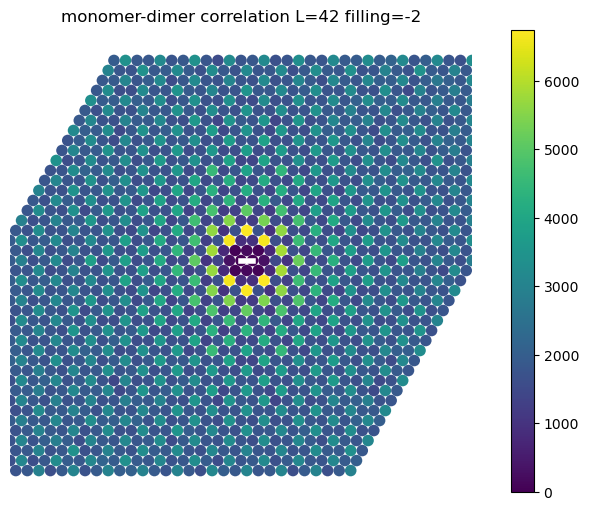

In [4]:
fig, ax = plt.subplots(1, 1, figsize=[10, 6])
ax.axis("off")
ax.set_xlim([-20, 20])
ax.set_ylim([-20, 20])
ax.set_aspect("equal")
ax.plot([0, 1], [0, 0], color="w", lw=4)

import matplotlib
patches = []
colors = []
N = matplotlib.colors.Normalize(vmin=0, vmax=np.max(vals))
for i in range(-n//2, n//2):
    for j in range(-n//2, n//2):
        patches.append(matplotlib.patches.Circle((i+j/2, j*np.sqrt(3)/2), radius=0.5))
        colors.append(matplotlib.colormaps["viridis"](N(vals[(i+n//2)%n - n//2, (j+n//2)%n-n//2])))

ax.add_collection(matplotlib.collections.PatchCollection(patches, facecolors=colors))
fig.colorbar(matplotlib.cm.ScalarMappable(norm=N, cmap="viridis"), ax=ax)
plt.title("monomer-dimer correlation L=42 filling=-2")

In [118]:
p1, p2, p3 = [], [], []
for l in read_mono_di_line("data/42x42-6-10000000-mono-di.dat", 42):
    v1, v2, v3 = 0, 0, 0
    for g in l:
        g = tuple(g)
        if g == (1, 2):
            v1 += 1
        elif g == (10, 0):
            v2 += 1
        elif g == (10, 10):
            v3 += 1
    p1.append(v1)
    p2.append(v2)
    p3.append(v3)

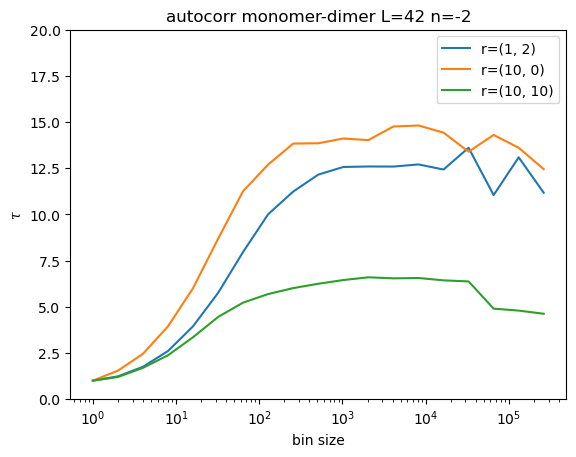

In [7]:
autocorr(p1, "r=(1, 2)")
autocorr(p2, "r=(10, 0)")
autocorr(p3, "r=(10, 10)")
plt.title("autocorr monomer-dimer L=42 n=-2")
plt.xscale("log")
plt.ylim([0, 20])
plt.legend()

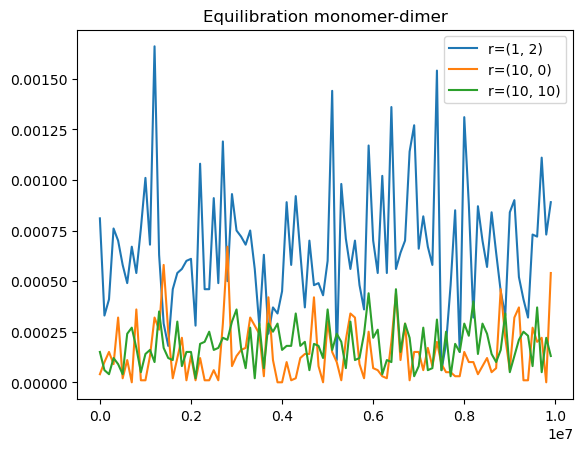

In [120]:
xs = np.arange(len(p1)//100000) * 100000
plt.plot(xs, bin(np.array(p1), 100000), label="r=(1, 2)")
plt.plot(xs, bin(np.array(p2), 100000), label="r=(10, 0)")
plt.plot(xs, bin(np.array(p3), 100000), label="r=(10, 10)")
plt.title("Equilibration monomer-dimer")
plt.legend()

Tilings

In [123]:
pos = list(read_trimers_line("data/102x102-3-1000-trimers.dat", 102))

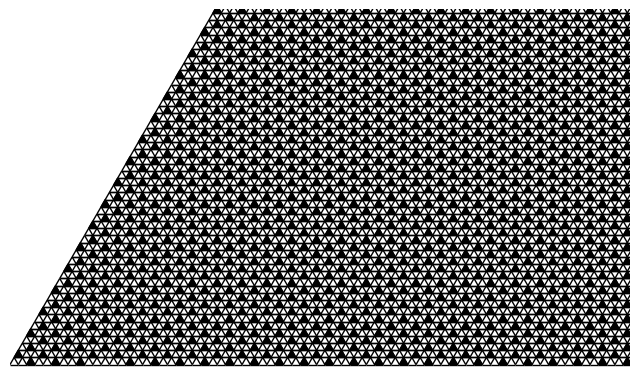

In [124]:
fig, ax = plt.subplots(1, 1, figsize=[8, 8])
pocket.draw_hexalattice(ax)
pocket.show_tiling(ax, (list(pos)[0], None), wf="tri", color="black", zoom=0.4)

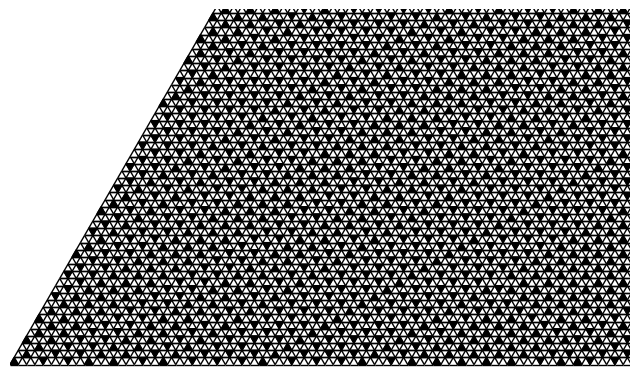

In [126]:
fig, ax = plt.subplots(1, 1, figsize=[8, 8])
pocket.draw_hexalattice(ax)
pocket.show_tiling(ax, (list(pos)[500], None), wf="tri", color="black", zoom=0.4)

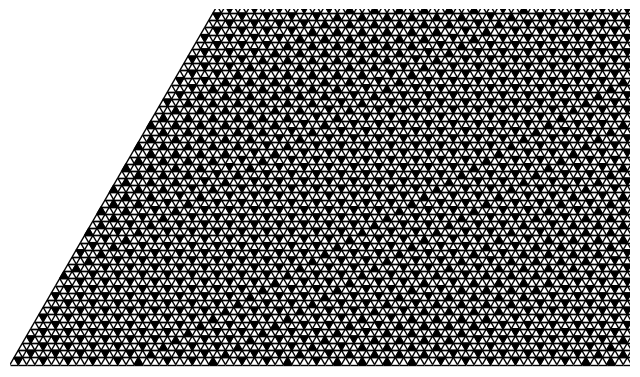

In [125]:
fig, ax = plt.subplots(1, 1, figsize=[8, 8])
pocket.draw_hexalattice(ax)
pocket.show_tiling(ax, (list(pos)[998], None), wf="tri", color="black", zoom=0.4)

# Trimer-Trimer correlation

In [40]:
x = read_trimers_cut("data/72x72-6-1000000-trimers-cut.dat", 72, stride=1, skip=500000)

Text(0.5, 0, 'r')

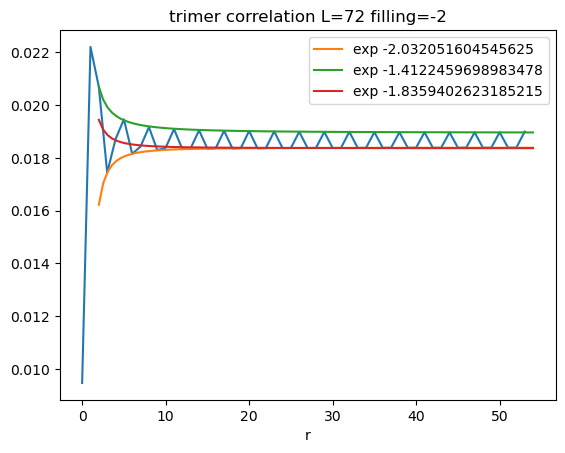

In [58]:
xr = x / x.sum()
xs = np.arange(x.shape[0])
import scipy
plt.plot(xs, xr)
def fit(x, A, B, C):
    return B * np.power(x, A) + C

P, _ = scipy.optimize.curve_fit(fit, xs[3::3], xr[3::3], p0=[-2, 1, 0.1])
plt.plot(np.linspace(2, xr.shape[0], 100), fit(np.linspace(2, xr.shape[0], 100), *P), label="exp " + str(P[0]))

P, _ = scipy.optimize.curve_fit(fit, xs[2::3], xr[2::3], p0=[-2, 1, 0.1])
plt.plot(np.linspace(2, xr.shape[0], 100), fit(np.linspace(2, xr.shape[0], 100), *P), label="exp " + str(P[0]))

P, _ = scipy.optimize.curve_fit(fit, xs[1::3], xr[1::3], p0=[-2, 1, 0.1])
plt.plot(np.linspace(2, xr.shape[0], 100), fit(np.linspace(2, xr.shape[0], 100), *P), label="exp " + str(P[0]))
plt.legend()
plt.title("trimer correlation L=72 filling=-2")
plt.xlabel("r")

In [61]:
x3 = read_trimers_cut("data/108x108-3-5000000-trimers-cut.dat", 108, skip=2500000, stride=10)

Text(0.5, 0, 'r')

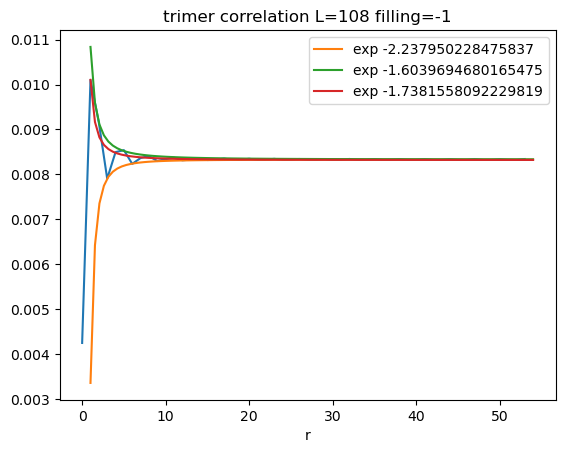

In [64]:
x = x3/5e6
xs = (np.arange(x.shape[0]))
import scipy
plt.plot(x)
def fit(x, A, B, C):
    return B * np.power(x, A) + C
P, _ = scipy.optimize.curve_fit(fit, xs[3::3], x[3::3], p0=[-2, 1, 0.1])
plt.plot(np.linspace(1, x.shape[0], 100), fit(np.linspace(1, x.shape[0], 100), *P), label="exp " + str(P[0]))

P, _ = scipy.optimize.curve_fit(fit, xs[2::3], x[2::3], p0=[-2, 1, 0.1])
plt.plot(np.linspace(1, x.shape[0], 100), fit(np.linspace(1, x.shape[0], 100), *P), label="exp " + str(P[0]))
P, _ = scipy.optimize.curve_fit(fit, xs[1::3], x[1::3], p0=[-2, 1, 0.1])
plt.plot(np.linspace(1, x.shape[0], 100), fit(np.linspace(1, x.shape[0], 100), *P), label="exp " + str(P[0]))
plt.legend()

plt.legend()
plt.title("trimer correlation L=108 filling=-1 skip=2.5M")
plt.xlabel("r")

In [58]:
d1 = read_trimers_r("data/108x108-3-5000000-trimers-cut.dat", 108, 2, skip=0, stride=1)
d2 = read_trimers_r("data/108x108-3-5000000-trimers-cut.dat", 108, 20, skip=0, stride=1)
d3 = read_trimers_r("data/108x108-3-5000000-trimers-cut.dat", 108, 50, skip=0, stride=1)

Text(0.5, 1.0, 'autocorr trimer-trimer L=108 n=-1 skip=1M')

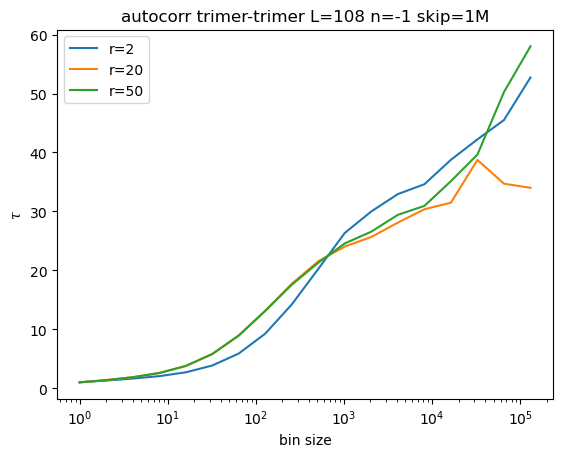

In [65]:
skip = 1000000
autocorr(d1[skip:], "r=2")
autocorr(d2[skip:], "r=20")
autocorr(d3[skip:], "r=50")
plt.legend()
plt.xscale("log")
plt.title("autocorr trimer-trimer L=108 n=-1 skip=1M")

Text(0.5, 1.0, 'equilib trimer-trimer L=108 n=-1')

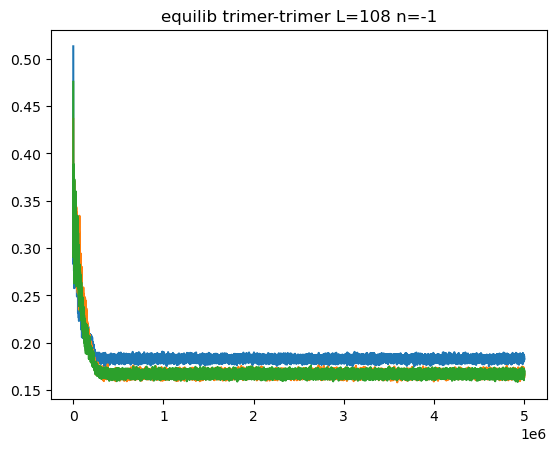

In [67]:
rng = np.arange(len(d1)//100) * 100
plt.plot(rng, bin(d1, 100))
plt.plot(rng, bin(d2, 100))
plt.plot(rng, bin(d3, 100))
plt.title("equilib trimer-trimer L=108 n=-1")

In [68]:
d1 = read_trimers_r("data/60x60-3-2000000-trimers-cut2.dat", 60, 2, skip=0, stride=1)
d2 = read_trimers_r("data/60x60-3-2000000-trimers-cut2.dat", 60, 10, skip=0, stride=1)
d3 = read_trimers_r("data/60x60-3-2000000-trimers-cut2.dat", 60, 25, skip=0, stride=1)

Text(0.5, 1.0, 'autocorr trimer-trimer L=60 n=-1 skip=1M')

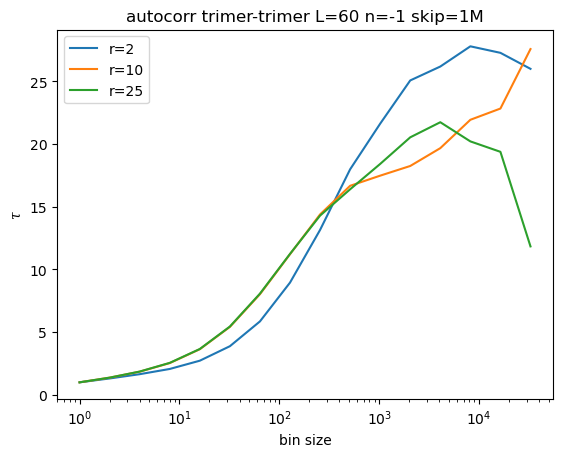

In [69]:
skip = 1000000
autocorr(d1[skip:], "r=2")
autocorr(d2[skip:], "r=10")
autocorr(d3[skip:], "r=25")
plt.legend()
plt.xscale("log")
plt.title("autocorr trimer-trimer L=60 n=-1 skip=1M")

Text(0.5, 1.0, 'equilib trimer-trimer L=60 n=-1')

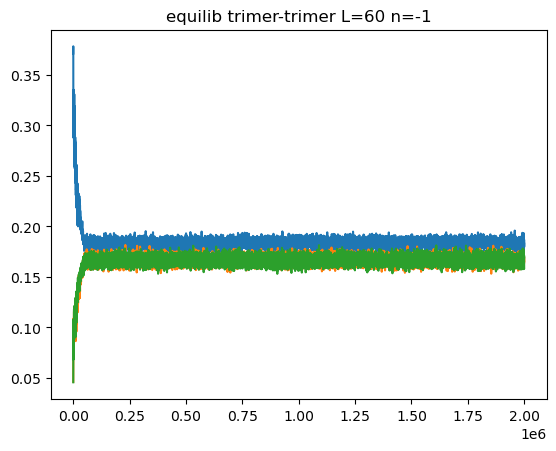

In [71]:
rng = np.arange(len(d1)//100) * 100
plt.plot(rng, bin(d1, 100))
plt.plot(rng, bin(d2, 100))
plt.plot(rng, bin(d3, 100))
plt.title("equilib trimer-trimer L=60 n=-1")

In [73]:
d1 = read_trimers_r("data/60x60-6-1000000-trimers-cut.dat", 60, 2, skip=0, stride=1)
d2 = read_trimers_r("data/60x60-6-1000000-trimers-cut.dat", 60, 10, skip=0, stride=1)
d3 = read_trimers_r("data/60x60-6-1000000-trimers-cut.dat", 60, 25, skip=0, stride=1)

Text(0.5, 1.0, 'autocorr trimer-trimer L=60 n=-2 skip=0.5M')

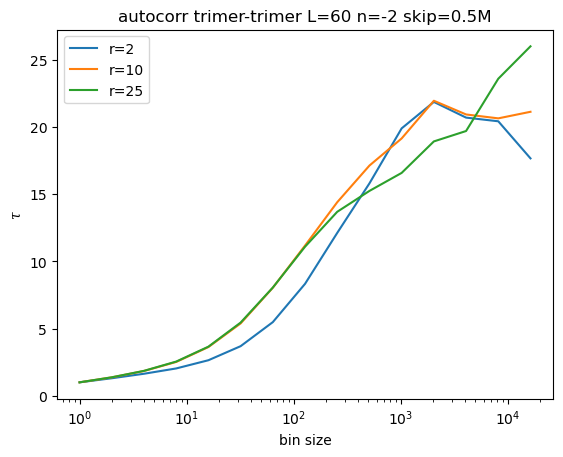

In [74]:
skip = 500000
autocorr(d1[skip:], "r=2")
autocorr(d2[skip:], "r=10")
autocorr(d3[skip:], "r=25")
plt.legend()
plt.xscale("log")
plt.title("autocorr trimer-trimer L=60 n=-2 skip=0.5M")

Text(0.5, 1.0, 'equilib trimer-trimer L=60 n=-2')

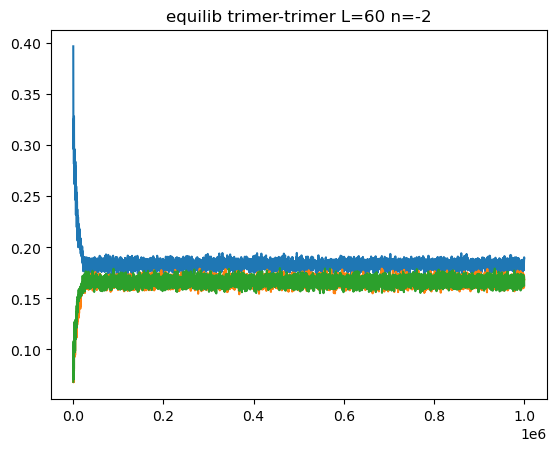

In [75]:
rng = np.arange(len(d1)//100) * 100
plt.plot(rng, bin(d1, 100))
plt.plot(rng, bin(d2, 100))
plt.plot(rng, bin(d3, 100))
plt.title("equilib trimer-trimer L=60 n=-2")

# Monomer-Monomer correlation

In [ ]:
avgs = []
xs = np.arange(6, 90, 6)
for i in xs:
    pocket.width = i
    pocket.height = i
    mono = read_monomers(f"data/{i}x{i}-3-500000-monomers.dat", (i//2-1, 0))
    avgs.append(np.mean(mono))

In [ ]:
factor = (xs/3)**2

import scipy
def fit(x, A, B):
    return B * np.power(x, A)
P, _ = scipy.optimize.curve_fit(fit, xs, np.array(avgs)*factor)
plt.plot(np.linspace(6, 90, 100), fit(np.linspace(6, 90, 100), *P), label=f"powerlaw with exp {P[0]:.3f}")
# plt.xscale("log")
# plt.yscale("log")
plt.legend()
plt.xlabel("$\\overline{r}$")
plt.plot(xs, np.array(avgs)*factor)

In [117]:
xs = np.arange(6, 108, 6)
vals = []
for i in xs:
    L = i
    d = read_monomers_cut(f"data/{i}x{i}-3-500000-monomers.dat", i)
    dn = np.zeros((max(d.keys())-min(d.keys()) + 1,))
    dk = np.arange(min(d.keys()), max(d.keys()) + 1)
    for key, value in sorted(d.items()):
        dn[key-min(d.keys())] = value

    dn[len(dn)//2] = 0
    dk = np.sin(np.pi/L * dk) / (np.pi/L)

    import scipy
    def fit(x, A, B):
        return B * np.power(np.abs(x), A)

    crit = np.logical_and(dn>0, dk>0)
    P, _ = scipy.optimize.curve_fit(fit, dk[crit], dn[crit], p0=[-0.25, 10])
    vals.append(P[0])

    # plt.plot(dk, dn)
    # plt.plot(dk, fit(dk, *P))

/home/kz345/miniconda3/envs/env/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


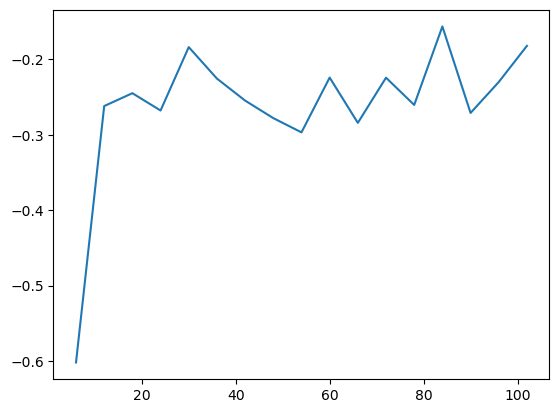

In [15]:
plt.plot(xs, vals)

/tmp/ipykernel_3071769/3294144254.py:14: RuntimeWarning: divide by zero encountered in power
  return B * np.power(np.abs(x), A)


Text(0.5, 1.0, 'monomer-monomer L=48 filling=-1')

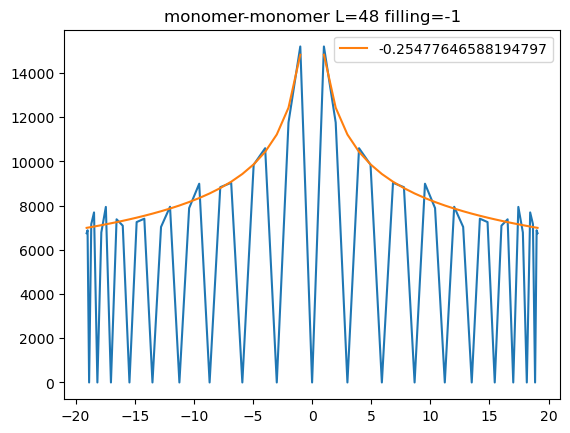

In [57]:
i = 60
L = i
d = read_monomers_cut(f"data/{i}x{i}-3-3000000-monomers.dat", i)
dn = np.zeros((max(d.keys())-min(d.keys()) + 1,))
dk = np.arange(min(d.keys()), max(d.keys()) + 1)
for key, value in sorted(d.items()):
    dn[key-min(d.keys())] = value

dn[len(dn)//2] = 0
dk = np.sin(np.pi/L * dk) / (np.pi/L)

import scipy
def fit(x, A, B):
    return B * np.power(np.abs(x), A)

crit = np.logical_and(dn>0, dk>0)
P, _ = scipy.optimize.curve_fit(fit, dk[crit], dn[crit], p0=[-0.25, 10])

plt.plot(dk, dn)
plt.plot(dk, fit(dk, *P), label=str(P[0]))

plt.legend()
plt.title("monomer-monomer L=48 filling=-1")

/tmp/ipykernel_3071769/1375468683.py:14: RuntimeWarning: divide by zero encountered in power
  return B * np.power(np.abs(x), A)


Text(0.5, 1.0, 'monomer-monomer L=48 filling=-2')

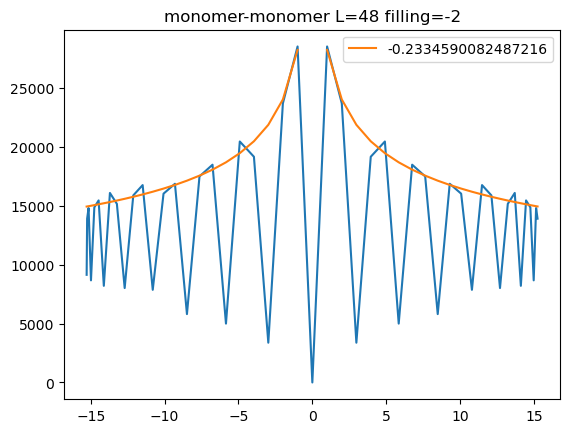

In [65]:
i = 48
L = i
d = read_monomers_cut(f"data/{i}x{i}-6-1000000-monomers.dat", i)
dn = np.zeros((max(d.keys())-min(d.keys()) + 1,))
dk = np.arange(min(d.keys()), max(d.keys()) + 1)
for key, value in sorted(d.items()):
    dn[key-min(d.keys())] = value

dn[len(dn)//2] = 0
dk = np.sin(np.pi/L * dk) / (np.pi/L)

import scipy
def fit(x, A, B):
    return B * np.power(np.abs(x), A)

crit = np.logical_and(dn>12000, dk>0)
P, _ = scipy.optimize.curve_fit(fit, dk[crit], dn[crit], p0=[-0.25, 10])

plt.plot(dk, dn)
plt.plot(dk, fit(dk, *P), label=str(P[0]))
plt.legend()
plt.title("monomer-monomer L=48 filling=-2")

In [101]:
p1 = read_monomers_r(f"data/60x60-3-3000000-monomers.dat", 60, [(0, 1), (0, 10), (0, 25), (24, 25)])

Text(0.5, 1.0, 'autocorr mono-mono L=60 n=-1 skip=0.5M')

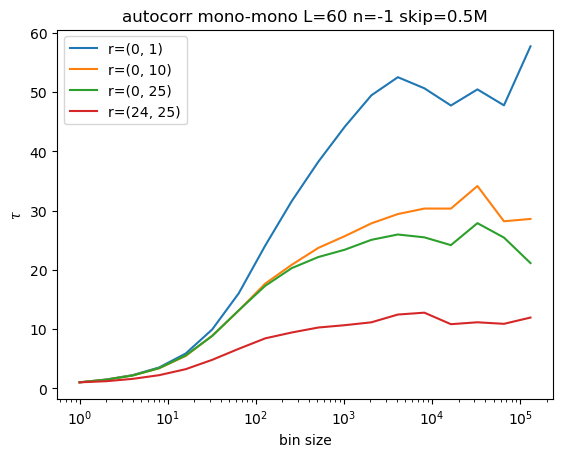

In [103]:
skip = 500000
autocorr(p1[(0, 1)][skip:], "r=(0, 1)")
autocorr(p1[(0, 10)][skip:], "r=(0, 10)")
autocorr(p1[(0, 25)][skip:], "r=(0, 25)")
autocorr(p1[(24, 25)][skip:], "r=(24, 25)")
plt.legend()
plt.xscale("log")
plt.title("autocorr mono-mono L=60 n=-1 skip=0.5M")

Text(0.5, 1.0, 'equilib mono-mono L=60 n=-1')

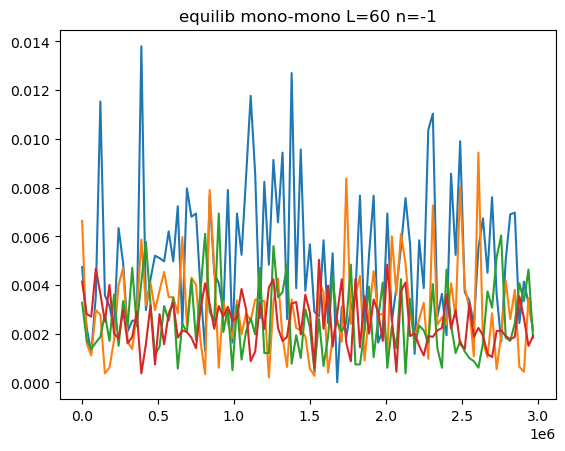

In [110]:
n = 30000
rng = np.arange(len(p1[(0, 1)])//n) * n
plt.plot(rng, bin(p1[(0, 1)], n))
plt.plot(rng, bin(p1[(0, 10)], n))
plt.plot(rng, bin(p1[(0, 25)], n))
plt.plot(rng, bin(p1[(24, 25)], n))
plt.title("equilib mono-mono L=60 n=-1")

# Monomer-Monomer finite size scaling

In [121]:
xs = np.arange(6, 108, 6)
corrs = []
rs = []
rrs = []

with open("data/monomer-data.dat", "r") as f:
    lines = f.readlines()

for i in xs:
    L = i
    # d = read_monomers_cut(f"data/{i}x{i}-3-3000000-monomers.dat", i)
    # dn = np.zeros((max(d.keys())-min(d.keys()) + 1,))
    # dk = np.arange(min(d.keys()), max(d.keys()) + 1)
    # for key, value in sorted(d.items()):
    #     dn[key-min(d.keys())] = value
    # dn[len(dn)//2] = 0

    dk = np.arange(-L//2+1, L//2)
    dn = np.array([float(x) for x in lines[0].strip().split()])
    lines = lines[1:]

    rrs.append(dk)

    dk = np.sin(np.pi/L * dk) / (np.pi/L)

    rs.append(dk)
    corrs.append(dn)

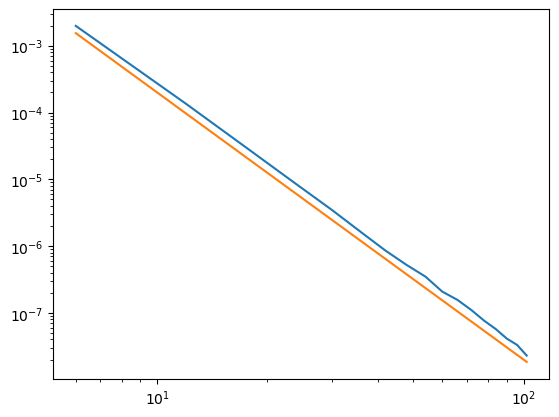

In [122]:
endpts = np.array([x[-1] for x in corrs])
vals = endpts / 3 / 3e6 / xs**2
plt.plot(xs, vals)
plt.plot(xs, 2/xs**4)
plt.xscale("log")
plt.yscale("log")

# import scipy
# def fit(x, A, B):
#     return B * np.power(np.abs(x), A)

# crit = np.logical_and(dn>0, dk>0)
# P, _ = scipy.optimize.curve_fit(fit, xs[1:], vals[1:], p0=[-0.25, 10])
# plt.plot(xs, fit(xs, *P))
# print(P)

Text(0.5, 1.0, 'mono-mono corr horizontal cut, n=-1, sweeps=3M')

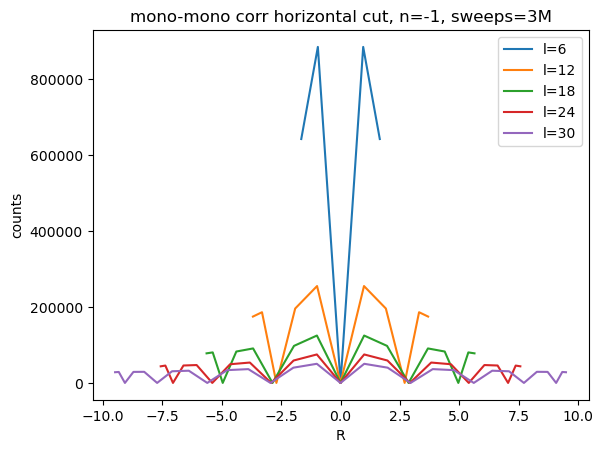

In [114]:
for a, b, x in zip(rs, corrs, xs[:5]):
    plt.plot(a, b, label=f"l={x}")
plt.legend()
plt.xlabel("R")
plt.ylabel("counts")
plt.title("mono-mono corr horizontal cut, n=-1, sweeps=3M")

Text(0, 0.5, 'MC counts at r=(0, L/2)')

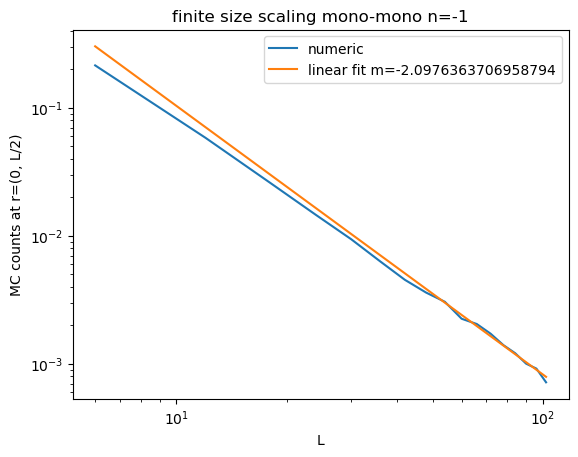

In [116]:
# plt.plot(xs, [c[-1]/c.sum() * x for c, x in zip(corrs, xs)])
ends = [c[-1]/(3000000) for c, x in zip(corrs, xs)]
plt.plot(xs, ends, label="numeric")

plt.xscale("log")
plt.yscale("log")
def fit(x, A, B):
    return B * np.power(np.abs(x), A)

import scipy
P, _ = scipy.optimize.curve_fit(fit, xs[8:], ends[8:], p0=[-0.25, 10])
plt.plot(xs, fit(xs, *P), label=f"linear fit m={P[0]}")
plt.legend()
plt.title("finite size scaling mono-mono n=-1")
plt.xlabel("L")
plt.ylabel("MC counts at r=(0, L/2)")

In [8]:
with open("data/monomer-data.dat", "w") as f:
    for line in corrs:
        f.write(f"{' '.join([str(x) for x in line])}\n")

# Monomer-Monomer 2D correlation

In [77]:
d = read_monomers(f"data/60x60-3-3000000-monomers.dat", 60)

Text(0.5, 1.0, 'monomer-monomer correlation L=60 filling=-1')

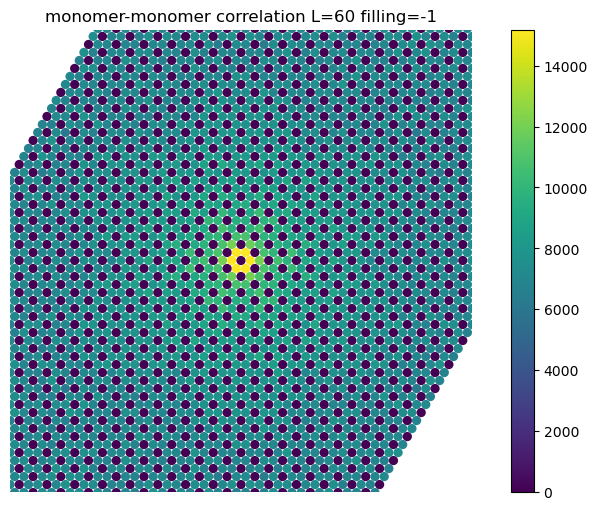

In [90]:
data = np.zeros((60, 60))
for key, value in d.items():
    data[key[0]+30, key[1]+30] = value

data[30, 30]=0

fig, ax = plt.subplots(1, 1, figsize=[10, 6])
ax.axis("off")
ax.set_xlim([-25, 25])
ax.set_ylim([-25, 25])
ax.set_aspect("equal")

import matplotlib
patches = []
colors = []
N = matplotlib.colors.Normalize(vmin=np.min(data), vmax=np.max(data))
n = 60
for i in range(-n//2, n//2):
    for j in range(-n//2, n//2):
        patches.append(matplotlib.patches.Circle((i+j/2, j*np.sqrt(3)/2), radius=0.5))
        colors.append(matplotlib.colormaps["viridis"](N(data[(i+n//2), (j+n//2)])))
ax.add_collection(matplotlib.collections.PatchCollection(patches, facecolors=colors))
fig.colorbar(matplotlib.cm.ScalarMappable(norm=N, cmap="viridis"), ax=ax)
plt.title("monomer-monomer correlation L=60 filling=-1")